In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import cv2
import matplotlib.pyplot as plot
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plot


from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Selecting Dataset Folder Paths
dir_ = Path('/content/drive/MyDrive/Image_Classification/data/train')
filepaths = list(dir_.glob(r'**/*.png'))
# Mapping the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Paths & labels
filepaths = pd.Series(filepaths, name = 'File').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenating...
df = pd.concat([filepaths, labels], axis=1)
df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)

In [ ]:
'''vc = df['Label'].value_counts()
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index,y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()'''





'vc = df[\'Label\'].value_counts()\nplt.figure(figsize = (9, 5))\nsns.barplot(x = vc.index,y = vc)\nplt.title("Number of images for each category in the Training Dataset", fontsize = 11)\nplt.show()'

In [ ]:
trainset_df,testset_df = train_test_split(df, train_size = 0.90, random_state = 42)
display(trainset_df.head())
testset_df.head()

,File,Label
4299,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
5090,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
2145,/content/drive/MyDrive/Image_Classification/da...,train_vehicles
11406,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
4974,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles


,File,Label
12456,/content/drive/MyDrive/Image_Classification/da...,train_vehicles
10557,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
10042,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
7810,/content/drive/MyDrive/Image_Classification/da...,train_non_vehicles
4864,/content/drive/MyDrive/Image_Classification/da...,train_vehicles


In [ ]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()
y_test = LE.fit_transform(testset_df["Label"])

In [ ]:
# Viewing data in training dataset
print('Training Dataset:')
print(f'Number of images: {trainset_df.shape[0]}')
print(f'Number of images with vehicle: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with Non-vehicle: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')
print(f'Number of images: {testset_df.shape[0]}')
print(f'Number of images with Vehicle: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with Non-vehicle: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 11264
Number of images with vehicle: 5841
Number of images with Non-vehicle: 5423

Test Dataset:
Number of images: 1252
Number of images with Vehicle: 643
Number of images with Non-vehicle: 609



In [ ]:
#rescale - Transform image size (normalization of data)
#shear_range - Random geometric transformations
#zoom_range - Images that will be zoomed
#rotation_range - Degree of image rotation
#width_shift_range - Image Width Change Range
#height_shift_range - Image height change range
#horizontal_flip - Rotate images horizontally
#vertical_flip - Rotate images vertically
#validation_split - Images that have been reserved for validation (0-1)
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
#Directory of training, validation and test images
'''dataframe - Dataframe containing the images directory
x_col - Column name containing the images directory
y_col - Name of the column containing what we want to predict
target_size - size of the images (remembering that it must be the same size as the input layer)
color_mode - RGB color standard
class_mode - binary class mode
batch_size - batch size
shuffle - Shuffle the data
seed - optional random seed for the shuffle
subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)'''
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 100,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 100,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 100)

print('Data generators are ready!')


Preparing the training dataset ...
Found 10138 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 1126 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 1252 validated image filenames belonging to 2 classes.
Data generators are ready!


In [ ]:
'''monitor - Metrics that will be monitored
patience - Number of times without improvement in the model, after these times the training is stopped
restore_best_weights - Restores best weights if training is interrupted'''
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, restore_best_weights = True)]

In [ ]:
#Construction of the model Inception
'''Step 1 - Base model creation
input_shape - Setting the height/width and RGB channels (75, 75, 3)
include_top - Fully connected layer will not be included on top
weights - Pre-training using imagenet'''
CNN_base_inc = InceptionV3(input_shape = (75, 75, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for layer in CNN_base_inc.layers:
  layer.trainable = False

In [ ]:
#Step 2 - Flattening
#Transforming the matrix to a vector to enter the Artificial Neural Network layer
x = layers.Flatten()(CNN_base_inc.output)

In [ ]:
#Step 3 - Dense Neural Networks
#Dense - All connected neurons
#units - Number of neurons that are part of the hidden layer
#activation - Activation function that will be inserted
#Dropout - is used to decrease the chance of overfitting (40% of input neurons are zeroed)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(1, activation='sigmoid')(x)
CNN_inc = Model(CNN_base_inc.input, x)

In [ ]:
#Step 4 - Model compilation and training
#Compile parameters:
'''optimizer - descent of the gradient and descent of the stochastic gradient
 loss - Loss function (binary_crossentropy as there is only one exit)
 metrics - Evaluation metrics (obs - more than one can be placed)
 Fit parameters:
 train_data - training database
 epochs - number of seasons
 validation_data - test database
 callbacks - Using EarlyStopping
 validation_steps - number of images to validation'''
# Compilation
CNN_inc.compile(optimizer = RMSprop(lr = 0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])

# Start of counting time
start = dt.datetime.now()

# Training and validation
CNN_inc_history = CNN_inc.fit(training_set, epochs = 35, validation_data = validation_set, callbacks = cb)

# End of Time Counting
end = dt.datetime.now()
time_CNN_inc = end - start
print ('\nTraining and validation time is: ', time_CNN_inc)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/35
102/102 [==============================] - 3830s 37s/step - loss: 0.2363 - accuracy: 0.9181 - val_loss: 0.1144 - val_accuracy: 0.9680
Epoch 2/35
102/102 [==============================] - 36s 356ms/step - loss: 0.1143 - accuracy: 0.9612 - val_loss: 0.1058 - val_accuracy: 0.9627
Epoch 3/35
102/102 [==============================] - 39s 378ms/step - loss: 0.0935 - accuracy: 0.9673 - val_loss: 0.0901 - val_accuracy: 0.9636
Epoch 4/35
102/102 [==============================] - 36s 356ms/step - loss: 0.0806 - accuracy: 0.9737 - val_loss: 0.0744 - val_accuracy: 0.9725
Epoch 5/35
102/102 [==============================] - 36s 357ms/step - loss: 0.0807 - accuracy: 0.9721 - val_loss: 0.0795 - val_accuracy: 0.9734
Epoch 6/35
102/102 [==============================] - 36s 352ms/step - loss: 0.0773 - accuracy: 0.9727 - val_loss: 0.0679 - val_accuracy: 0.9751
Epoch 7/35
102/102 [==============================] - 36s 353ms/step - loss: 0.0753 - accuracy: 0.9726 - val_loss: 0.0927 - val_ac

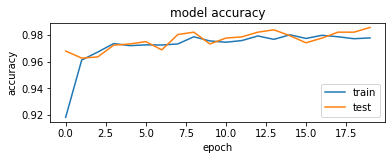

In [ ]:
plot.subplot(2,1,1)
plot.plot(CNN_inc_history.history['accuracy'])
plot.plot(CNN_inc_history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

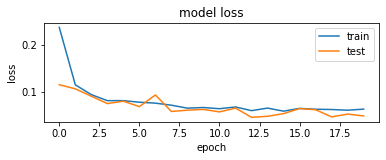

In [ ]:
plot.subplot(2,1,2)
plot.plot(CNN_inc_history.history['loss'])
plot.plot(CNN_inc_history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

In [ ]:
model_json = CNN_inc.to_json()
with open("/content/drive/MyDrive/Image_Classification/data/Inception.json", "w") as json_file:
  json_file.write(model_json)
  CNN_inc.save("/content/drive/MyDrive/Image_Classification/data/Inception.h5")
  print("Saved model to disk")
  CNN_inc.save_weights("/content/drive/MyDrive/Image_Classification/data/Inception.h5")

Saved model to disk
